📌 Trabajo Final de Diplomatura en Inteligencia Artificial - Grupo 6 - Cohorte  2024

# Sistema para la clasificación correcta de residuos.


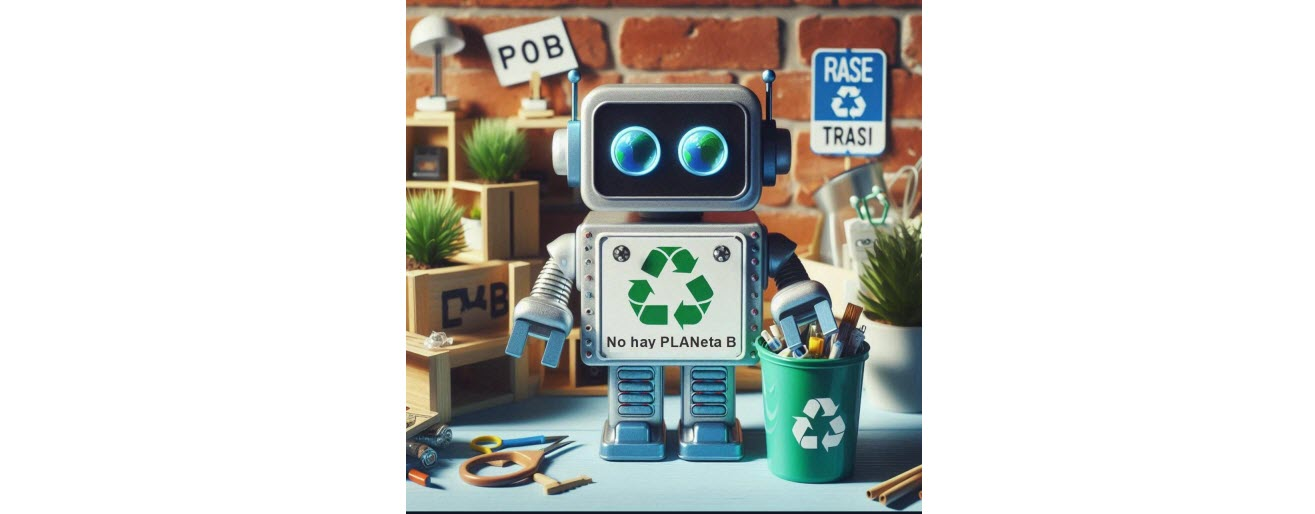

### Integrantes:  
    Valentina Botta  
    Gustavo Lucarella   
    Mauricio Magistocchi   
    Edgardo Eliseo Cornelio  


 **🟢 "En este cuaderno, clasificaremos los desechos (trash) o no, utilizando una Red Neuronal Convolucional (CNN).".**

# <div id="ToC" style="padding:10px;color:white;margin:5;font-size:170%;text-align:left;display:fill;border-radius:15px;background-color:#294B8E;overflow:hidden;font-weight:700">Tabla de contenidos</div>

<a id="toc"></a>
- [1. Configuracion](#1)
    - [1.1 Paquetes y Bibliotecas](#1.1-Paquetes-y-Bibliotecas)
    - [1.2. Cargar los Datos](#1.2.-Cargar-los-Datos)
- [2. Division](#2.-Division)
- [3. Exploracion de Datos](#3.-Exploracion-de-Datos)
- [4. Aumento de Datos](#4.-Aumento-de-Datos)
- [5. Modelado](#5.-Modelado)
- [6. Evaluacion](#6.-Evaluacion)
- [7. Imagenes Predecidas](#7.-Imagenes-Predecidas)

# <a id="1"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">1. Configuracion</div>

<a id="1.1"></a>
# <b><span style='color:#8D6D9B'>1.1 Paquetes y Bibliotecas</span></b> <a href="#Tabla-de-contenidos" style="font-size:10px;"> ToC</a>


In [11]:
import os
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf
import random
import shutil             # to copy images to another directory 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
plt.style.use('ggplot')

<a id="1.2"></a>
# <b><span style='color:#8D6D9B'>1.2. Cargar los Datos</span></b>

In [12]:
#dataDirList = ['/kaggle/input/garbage-classification/Garbage classification/Garbage classification/' , 
#              '/kaggle/input/d/mostafaabla/garbage-classification/garbage_classification/']

dataDirList = ['/mnt/c/Users/edgardo/git-edgardo/Austral/TF-Diplo/DataSet/Dataset_splits/train/']

#selectedClasses = ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic' ,'white-glass']
selectedClasses = ['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [13]:
imgPaths = []
labels = []
for dataDir in dataDirList:
    for className in os.listdir(dataDir):
        if className in selectedClasses :
            classPath = os.path.join(dataDir,className)
            for img in os.listdir(classPath):
                imgPath = os.path.join(classPath,img)
                imgPaths.append(imgPath)
                if className == 'white-glass':
                    className = 'glass'
                labels.append(className)
            
# Convert the 2 lists to dataframe to easy use 
df = pd.DataFrame({
    'imgPath':imgPaths,
    'label':labels
})

df = df.sample(frac=1).reset_index(drop=True)            # Shuffle

df

imgPath      label
0     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...  cardboard
1     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...  cardboard
2     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...    plastic
3     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...    compost
4     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...      paper
...                                                 ...        ...
7112  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...    compost
7113  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...      metal
7114  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...      metal
7115  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...      trash
7116  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...      glass

[7117 rows x 2 columns]

 <a id="2"></a>
# <div style="padding:10px;color:white;margin:5;font-size:170%;text-align:left;display:fill;border-radius:15px;background-color:#294B8E;overflow:hidden;font-weight:700">2. Division</div>

In [14]:
# get the ratio such as 15% of each class for testing 
def DataFrameSpliting(df , ratio , classesList):
    
    trainDf = pd.DataFrame(columns = ['imgPath','label'])
    testDf = pd.DataFrame(columns = ['imgPath','label'])
    for clas in classesList :
        tempDf = df[df['label'] == clas]
        lastIndex = int(len(tempDf) * ratio)
        trainClassDf = tempDf[:lastIndex]
        testClassDf = tempDf[lastIndex:]
        trainDf = pd.concat([trainDf , trainClassDf] , axis=0)
        testDf = pd.concat([testDf , testClassDf] , axis=0)
        
    return trainDf.sample(frac=1).reset_index(drop=True) , testDf.sample(frac=1).reset_index(drop=True)  # shuffling , reset index

In [15]:
classList = list(df['label'].unique())
trainDf , testDf = DataFrameSpliting(df , 0.85 , classList)

In [ ]:
# Another way for spliting a dataframe 

# def splitingData(dataFrame , ratio):
#     lastIndex = int(len(dataFrame) * ratio)
#     trainDf = dataFrame[:lastIndex]
#     testDf = dataFrame[lastIndex:]
#     return trainDf , testDf

In [16]:
trainDf

imgPath      label
0     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...      trash
1     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...      paper
2     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...  cardboard
3     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...      trash
4     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...      metal
...                                                 ...        ...
6042  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...    plastic
6043  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...      trash
6044  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...    plastic
6045  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...      trash
6046  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...    compost

[6047 rows x 2 columns]

In [17]:
trainDf['label'].value_counts()

label
compost      929
paper        921
glass        921
trash        880
cardboard    861
plastic      823
metal        712
Name: count, dtype: int64

In [18]:
testDf

imgPath    label
0     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...    trash
1     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...  plastic
2     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...    trash
3     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...  compost
4     /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...    paper
...                                                 ...      ...
1065  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...    trash
1066  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...    paper
1067  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...    metal
1068  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...    trash
1069  /mnt/c/Users/edgardo/git-edgardo/Austral/TF-Di...  compost

[1070 rows x 2 columns]

In [19]:
testDf['label'].value_counts()

label
compost      164
paper        163
glass        163
trash        156
cardboard    152
plastic      146
metal        126
Name: count, dtype: int64

 <a id="3"></a>
# <div style="padding:10px;color:white;margin:5;font-size:170%;text-align:left;display:fill;border-radius:15px;background-color:#294B8E;overflow:hidden;font-weight:700">3. Exploracion de Datos</div>

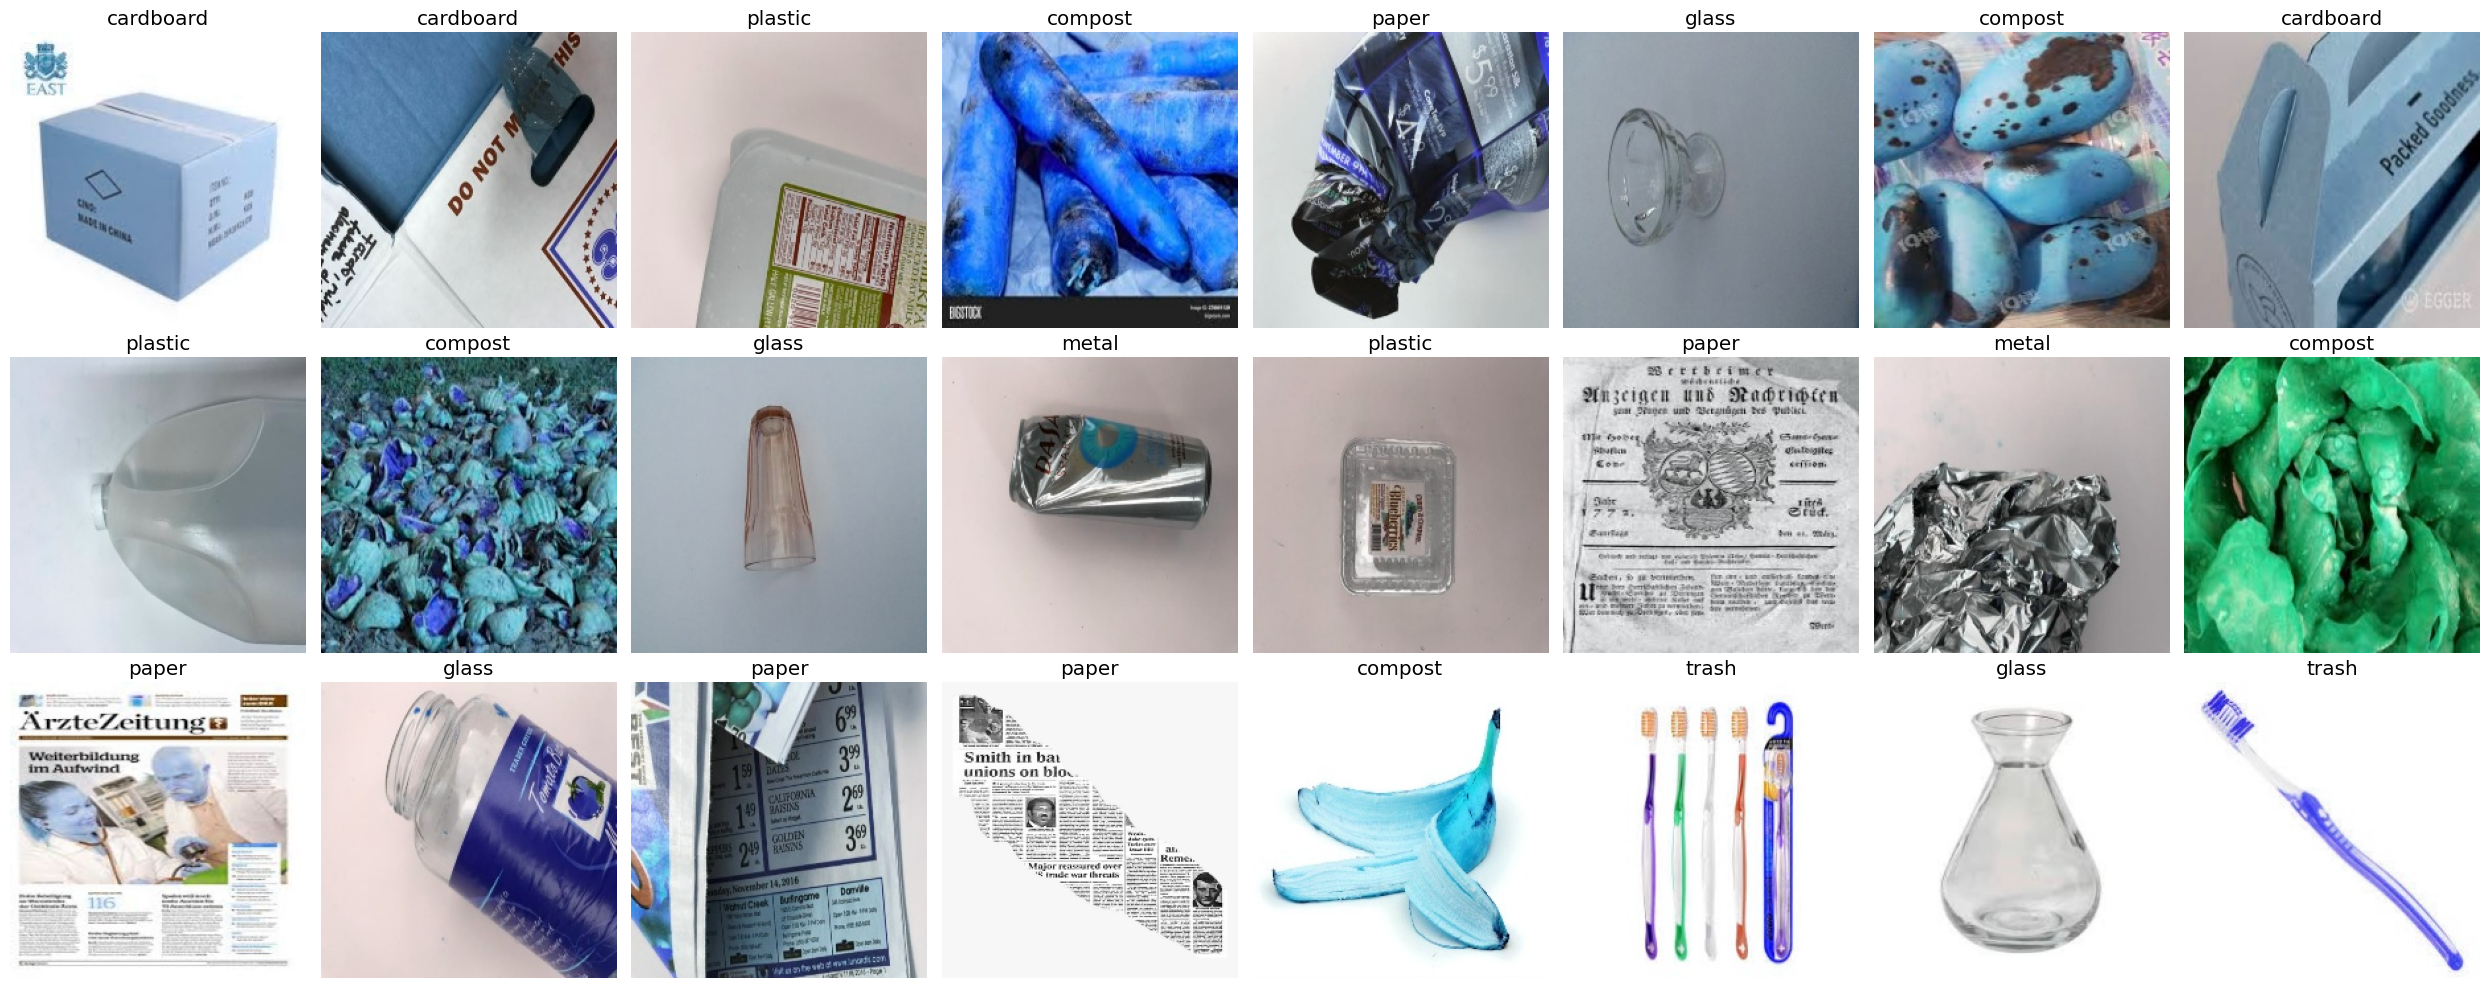

In [20]:
imgPaths = df['imgPath']
fig, axs = plt.subplots(3, 8, figsize=(25, 10))

axs = axs.flatten()

for ax,imgPath in zip(axs , imgPaths):
    label = str(imgPath).split('/')[-2]    # extract label of an imgae from a path 
    img = cv2.imread(imgPath)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

 <a id="4"></a>
# <div style="padding:10px;color:white;margin:5;font-size:170%;text-align:left;display:fill;border-radius:15px;background-color:#294B8E;overflow:hidden;font-weight:700">4. Aumento de Datos</div>

In [21]:
datagenTrain = ImageDataGenerator(
            rescale=1./255,
            zoom_range=(1.0, 1.2),   # zoom in 
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=45,
)

In [22]:
IMG_SIZE = (224,224)

trainGenerator = datagenTrain.flow_from_dataframe(
    trainDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64 ,                    # Generate 64 image from the datagenTrain (flipped , rotated , zoomed , ....)  at once 
    class_mode='categorical'
)


datagenTest = ImageDataGenerator( rescale=1./255 )

testGenerator = datagenTest.flow_from_dataframe(
    testDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=8 ,
    class_mode='categorical',
    shuffle=False
)


print(f"Training set size: {trainGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Found 6041 validated image filenames belonging to 7 classes.


/home/edgardo/miniconda3/envs/py310/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 6 invalid image filename(s) in x_col="imgPath". These filename(s) will be ignored.
  warnings.warn(


Found 1069 validated image filenames belonging to 7 classes.
Training set size: 6041
Testing set size: 1069


/home/edgardo/miniconda3/envs/py310/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="imgPath". These filename(s) will be ignored.
  warnings.warn(


In [59]:
import pandas as pd
import os

# Carga tu DataFrame, ajusta el nombre del archivo si es necesario
# data = pd.read_csv("/mnt/c/Users/edgardo/git-edgardo/Austral/TF-Diplo/DataSet/Dataset_splits/archivo.csv")  # Cambia a la ubicación de tu archivo

# Columna que contiene las rutas de las imágenes (ajústalo si usas otro nombre)
image_paths = data['imgPath']

# Lista para almacenar archivos inválidos
invalid_files = []

# Verificar la existencia de cada archivo
for img_path in image_paths:
    if not os.path.exists(img_path):
        invalid_files.append(img_path)

# Mostrar archivos inválidos
if invalid_files:
    print("Archivos inválidos encontrados:")
    for file in invalid_files:
        print(file)
else:
    print("No se encontraron archivos inválidos.")


NameError: name 'data' is not defined

In [31]:
#print(trainGenerator)
print(testGenerator)

 <a id="5"></a>
# <div style="padding:10px;color:white;margin:5;font-size:170%;text-align:left;display:fill;border-radius:15px;background-color:#294B8E;overflow:hidden;font-weight:700">5. Modelado</div>

In [23]:
with tf.device('/GPU:0'):          # to use GPU
    Model = Sequential([
        
#         Resizing(IMG_SIZE),
        
#         Rescaling(1./255),     These two steps ,we did perform them above with test and image generator 
    
        MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)),
        
        Flatten(),                                     # because we ignore the flatten and dense layers when include_top = False 
        
        Dense(64,activation='relu'),
        
        BatchNormalization(),
        
        Dropout(0.08),

        Dense(6 ,activation='softmax')
    ])

I0000 00:00:1730047426.806721    1476 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-27 13:43:46.877393: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [36]:
Model = Sequential([
    MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)),
    Flatten(),                                     # Ignora las capas de flatten y dense cuando include_top = False 
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.08),
    Dense(7, activation='softmax')
])


In [37]:
preTrainedModel = Model.layers[0]
for layer in preTrainedModel.layers[:-4]:           # freez all layers except the first and last 3 layers, we will make them trainable (weghts changes with training)
    layer.trainable = False

In [38]:
Model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['accuracy'])

In [39]:
history = Model.fit(trainGenerator,
                    validation_data = testGenerator, 
                    epochs=50,
#                     batch_size=64,   # we define it above inside trainGenerator
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(
                                       patience=4,
                                       monitor='val_accuracy',
                                       restore_best_weights=True)])

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.7096 - loss: 0.8632 - val_accuracy: 0.8138 - val_loss: 0.6360
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8586 - loss: 0.4072 - val_accuracy: 0.8746 - val_loss: 0.4072
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9021 - loss: 0.2866 - val_accuracy: 0.8784 - val_loss: 0.4042
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.9311 - loss: 0.2213 - val_accuracy: 0.8672 - val_loss: 0.4289
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9362 - loss: 0.1947 - val_accuracy: 0.8718 - val_loss: 0.4358
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9460 - loss: 0.1679 - val_accuracy: 0.8746 - val_loss: 0.4370
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9591 - loss: 0.1341 - val_accuracy: 0.8943 - val_loss: 0.3920
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9609 - loss: 0.1080 - val_accuracy: 0.8915 - v

In [40]:
Model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     4,014,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,127,895 (57.71 MB)

 Trainable params: 4,427,527 (16.89 MB)

 Non-trainable params: 1,845,312 (7.04 MB)

 Optimizer params: 8,855,056 (33.78 MB)

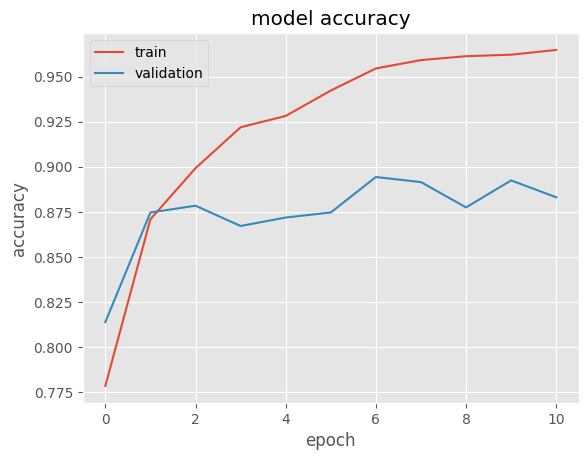

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

 <a id="6"></a>
# <div style="padding:10px;color:white;margin:5;font-size:170%;text-align:left;display:fill;border-radius:15px;background-color:#294B8E;overflow:hidden;font-weight:700">6. Evaluacion</div>

In [42]:
predictions = Model.predict(testGenerator)

134/134 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step


In [43]:
trainGenerator.class_indices

{'cardboard': 0,
 'compost': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

In [44]:
trueClasses = testGenerator.classes
trueClasses[:10]

[6, 5, 6, 1, 4, 0, 5, 6, 0, 2]

In [45]:
predictedClasses = predictions.argmax(axis=-1)
predictedClasses[:10]

array([6, 5, 6, 1, 4, 0, 5, 6, 0, 2])

In [46]:
test_loss, test_accuracy = Model.evaluate(testGenerator)
test_accuracy

134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.8994 - loss: 0.3948


0.8942937254905701

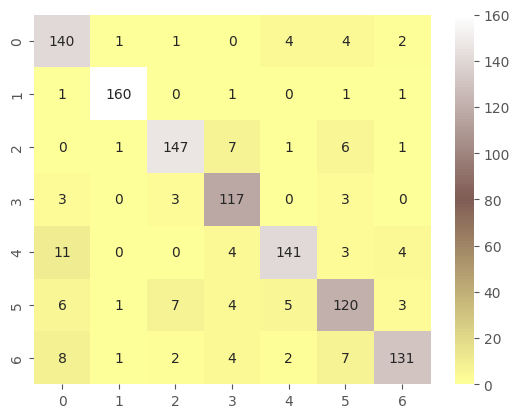

In [47]:
CM = confusion_matrix(trueClasses, predictedClasses)
sns.heatmap(CM, center = True,cmap='terrain',annot=True ,fmt='.5g')
plt.show()

In [48]:
ClassificationReport = classification_report(trueClasses, predictedClasses)
print('Classification Report is : \n', ClassificationReport )

Classification Report is : 
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       152
           1       0.98      0.98      0.98       164
           2       0.92      0.90      0.91       163
           3       0.85      0.93      0.89       126
           4       0.92      0.87      0.89       163
           5       0.83      0.82      0.83       146
           6       0.92      0.85      0.88       155

    accuracy                           0.89      1069
   macro avg       0.89      0.89      0.89      1069
weighted avg       0.90      0.89      0.89      1069



 <a id="7"></a>
# <div style="padding:10px;color:white;margin:5;font-size:170%;text-align:left;display:fill;border-radius:15px;background-color:#294B8E;overflow:hidden;font-weight:700">7. Imagenes Predecidas</div>

In [49]:

images = []
predictedClasses = []
trueClasses = []


class_labels = list(testGenerator.class_indices.keys())

for i in range(len(testGenerator)):
    img_batch, true_labels_batch = next(testGenerator)  # Get next batch
    true_class_idx = np.argmax(true_labels_batch[0])  # Get the true class index
    
    # Predict the class for the image
    prediction = Model.predict(img_batch)
    predicted_class_idx = np.argmax(prediction[0])  # Get the predicted class index
    
    # Convert the class indices to class labels
    predicted_class = class_labels[predicted_class_idx]
    true_class = class_labels[true_class_idx]
    
    images.append(np.squeeze(img_batch[0]))
    predictedClasses.append(predicted_class)
    trueClasses.append(true_class)
    
    if i >= 24:  # For example, only plot 24 images
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


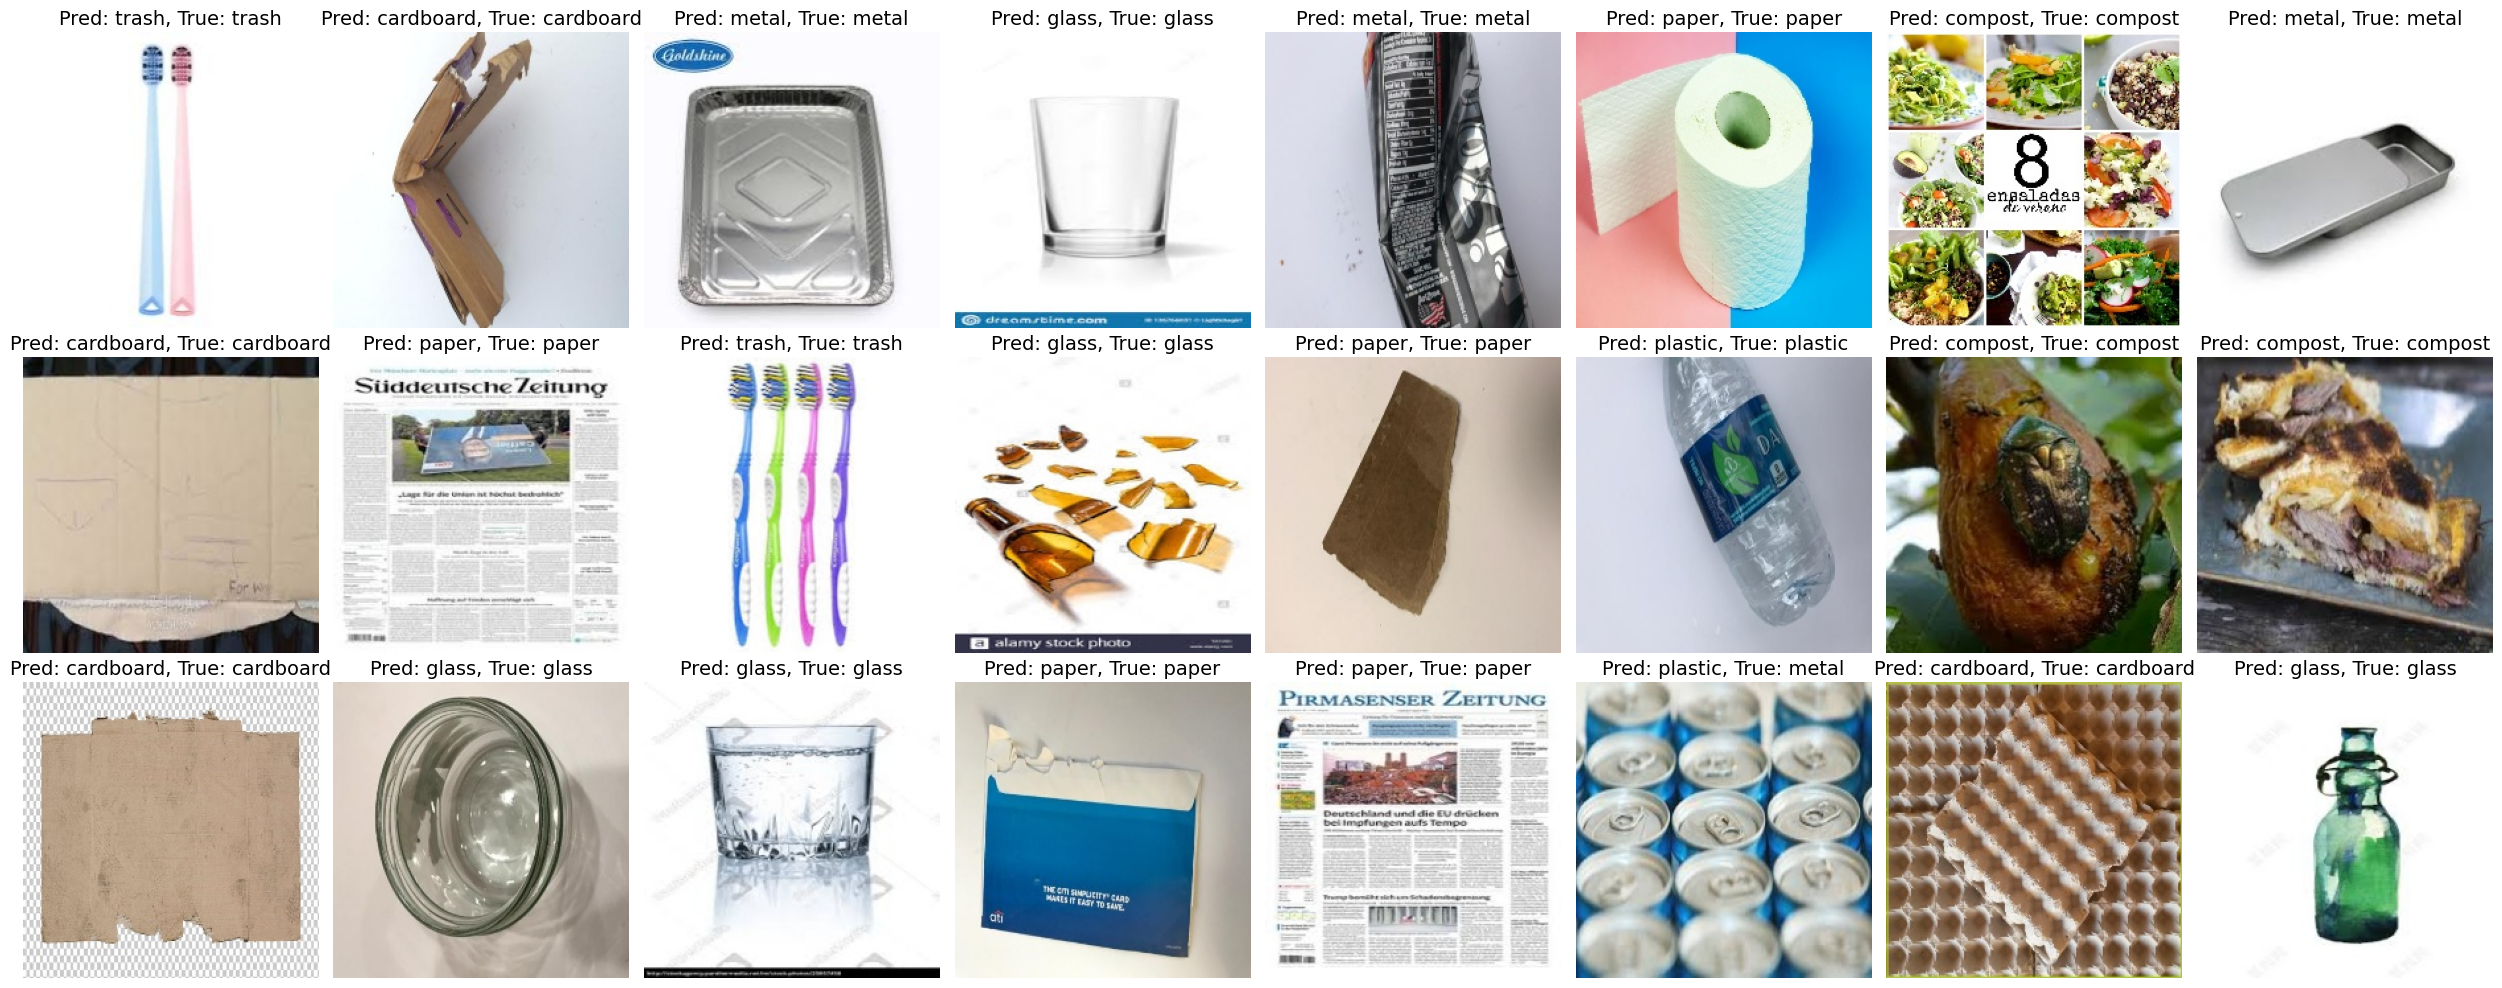

In [50]:
fig, axs = plt.subplots(3, 8, figsize=(25, 10))


axs = axs.flatten()

for ax,img , pred , true in zip(axs , images , predictedClasses , trueClasses):
    ax.imshow(img)
    ax.set_title(f"Pred: {pred}, True: {true}" ,fontsize=14)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# <a id="7"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">7. Guardando el modelo</div>

In [52]:
Model.save('/mnt/c/Users/edgardo/git-edgardo/Austral/TF-Diplo/Tensorflow2/model_NoHayPlanetaB_tf2.keras')

In [54]:
Model.save_weights('/mnt/c/Users/edgardo/git-edgardo/Austral/TF-Diplo/Tensorflow2/model_NoHayPlanetaB.weights.h5')

<a href="#toc" class="btn btn-success btn-lg active" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to Colors">Go to TOP</a>